In [1]:
import os
import sys
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp
import matplotlib.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
from detection_code.storms_functions_io import py_files, read_WW3_HS_file, read_ERA5_HS_file
from detection_code.storms_functions_detect import get_storm_by_timestep, rename_duplicates, get_storm_info_from_savemap
from detection_code.storms_functions_tracking import track_for_1_file,track_for_1_transition
import detection_code.params_detect as cte

import scipy.ndimage as ndimage
from detection_code.storms_functions_geo import distance_matrix, spatial_filter

In [3]:
year = 2023
final_year = 2023
month = 1
final_month = 2

day_start = pd.Timestamp(year,month,1)
day_end = pd.Timestamp(final_year,(final_month),1)
A = pd.date_range(day_start,day_end,freq='MS')
months_years = np.vstack((A.month,A.year)).T

mm,yy = months_years[0]

# 1st step : detection

## Starting point

In [4]:
filename = cte.FORMAT_IN.replace('YYYY',f'{yy:04d}').replace('MM',f'{mm:02d}')
ds = read_WW3_HS_file(cte.PATH,filename)
ds
# only 2 variables : hs and areakm2 (this variable is computed while opening the file)

<xarray.Dataset> Size: 227MB
Dimensions:    (longitude: 720, latitude: 317, time: 248)
Coordinates:
  * longitude  (longitude) float32 3kB -180.0 -179.5 -179.0 ... 179.0 179.5
  * latitude   (latitude) float32 1kB -78.0 -77.5 -77.0 -76.5 ... 79.0 79.5 80.0
  * time       (time) datetime64[ns] 2kB 2023-01-01 ... 2023-01-31T21:00:00
Data variables:
    hs         (time, latitude, longitude) float32 226MB ...
    areakm2    (latitude, longitude) float32 913kB 642.6 642.7 ... 536.8 536.7
Attributes: (12/104)
    WAVEWATCH_III_version_number:     7.14
    WAVEWATCH_III_switches:           NOGRB SCRIP SCRIPNC TRKNC DIST MPI PR3 ...
    SIN4 namelist parameter BETAMAX:  1.3
    data_type:                        OCO straight grid
    format_version:                   1.2
    title:                            WAVEWATCH-III HINDCAST
    ...                               ...
    CICEN:                            2.00
    LICE:                             40000.
    FLAGTR:                           4
    FACBERG:                          0.2
    start_date:                       2023-01-01 00:00:00
    stop_date:                        2023-01-31 21:00:00

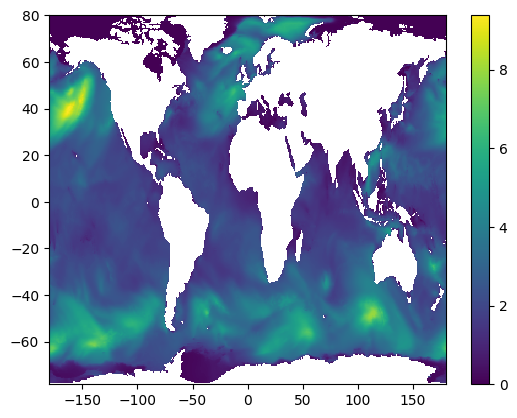

In [5]:
it = 0
ds0 = ds.isel(time=it)
im = plt.pcolormesh(ds0.longitude,ds0.latitude,ds0.hs)
plt.colorbar(im)

## function 'get_storm_by_timestep'

In [26]:
def get_storm_by_timestep2(ds1,levels,Npix_min,amp_thresh, d_thresh_min, d_thresh_max, area_forgotten_ratio, min_area, plot_output = False, plot_example = False):
    # --- concat [-180: 360] ----
    ds2 = ds1.copy(deep=True).sel(longitude=slice(None,0))
    ds2['longitude'] = ds2['longitude']+360.
    dsTot = xr.concat((ds1,ds2),dim='longitude')
    if plot_example:
        plt.figure(figsize=(12,5))
        im = plt.pcolormesh(dsTot.longitude,dsTot.latitude,dsTot.hs,cmap='jet')
        plt.colorbar(im)
        plt.title('Hs after concatenation (map from -180 to 360)')
    
    swh_filt0 = spatial_filter(dsTot['hs'].data, 0.5, 4., 4.)
    swh_filt = dsTot['hs'].copy(data=swh_filt0)
        
    field20 = swh_filt
    count_storms = 0

    area2 = dsTot['areakm2'].data
    field20 = field20.where(~np.isnan(field20),0)
    field2 = field20.data

    NX = ds1.sizes['longitude']

    llon2,llat2 = np.meshgrid(dsTot['longitude'],dsTot['latitude'])

    regions_old = np.zeros_like(field2.data,dtype='int')-100
    to_save = np.zeros_like(field2.data,dtype='int')-100
    to_save_intersec = np.zeros_like(field2.data,dtype='int')-100
    
    countst = 0
    if plot_example:
        fig2,axs2 = plt.subplots(4,3,figsize=(20,12))
        fig,axs = plt.subplots(3,2,figsize=(16,12))
        level_selec = 24
        

    for ilev, lev in enumerate(levels):
        # --- 1. Find all regions with Hs greater than ilev  ---------------
        regions, nregions = ndimage.label( (field2 > lev).astype(int) )
        regions[regions==0] =-100
        
        regions_new, regions_only_big_area, regions_interOnly = rename_duplicates(regions,NX)
        uregions = np.unique(regions_new[regions_new>-100])
        
        if plot_example:
            if ilev>=13:
                if ilev ==13:
                    vmax=2
                else:
                    vmax=None
                ax = axs2[(ilev-13)//3,(ilev-13)%3]
                im = ax.pcolormesh(dsTot.longitude,dsTot.latitude,regions_new,cmap='jet',vmin=-1,vmax=vmax)
                plt.colorbar(im,ax=ax)
                ax.set_title('Hs lim = '+str(lev)+' m')
                plt.tight_layout()
            
            if ilev == level_selec:
                ax = axs[0,0]
                im = ax.pcolormesh(dsTot.longitude,dsTot.latitude,regions,cmap='jet',vmin=-1)
                plt.colorbar(im,ax=ax)
                ax.set_title('labelisation step, num lev = '+str(ilev)+', hs lim = '+str(lev))
                ax = axs[0,1]
                im = ax.pcolormesh(dsTot.longitude,dsTot.latitude,regions_new,cmap='jet',vmin=-1,vmax=regions_new.max())
                plt.colorbar(im,ax=ax)
                ax.set_title('renamed regions ')
                ax = axs[1,0]
                im = ax.pcolormesh(dsTot.longitude,dsTot.latitude,regions_interOnly,cmap='jet',vmin=-1,vmax=regions_new.max())
                plt.colorbar(im,ax=ax)
                ax.axvline(0,ls='--',color='m')
                ax.axvline(180,ls='--',color='m')
                ax.set_title('regions at intersection (0° and 180°)')
                ax = axs[1,1]
                im = ax.pcolormesh(dsTot.longitude,dsTot.latitude,regions_only_big_area,
                                   cmap='jet',vmin=-1,vmax=regions_new.max())
                plt.colorbar(im,ax=ax)
                ax.set_title('unique regions with only big area')
                ax = axs[2,0]
                im = ax.pcolormesh(dsTot.longitude,dsTot.latitude,(to_save_intersec>-1),
                                   cmap='grey',vmin=0,vmax=1)
                plt.colorbar(im,ax=ax)
                ax.set_title('already saved at previous step')
                ax = axs[2,1]
                im = ax.pcolormesh(dsTot.longitude,dsTot.latitude,(to_save_intersec<-1)*(regions_new >-1),#+1)*(regions_new >-1),
                                   cmap='grey',vmin=0,vmax=1)
                plt.colorbar(im,ax=ax)
                ax.set_title('regions - (already saved)')
                

        for iir, ir in enumerate(uregions):
            # ---- 
            regionNB = (regions_new == ir)
            regionNB_nodupl = (regions_only_big_area == ir)
            # == regions_new contains duplicates ===
            is_already_saved = np.any((to_save_intersec[regionNB]>-1))
            u_regions_saved_in = np.unique((to_save_intersec[(regionNB) & (to_save_intersec>-1)]))
            u_old_regions_in0 = np.unique((regions_old[(to_save_intersec<-2) & (regionNB) & (regions_old>-1)])) # regions that are not saved
            u_old_regions_out0 = np.unique(regions_old[(regionNB) & (to_save_intersec>-1)])
            u_old_regions_in = np.setdiff1d(u_old_regions_in0, u_old_regions_out0)

            if is_already_saved: # ---- inside the region, there is already a save storm:
                # --- case : there was also another "storm" detected at previous level that did not match all required flags for saving
                # -- get area of saved storms ---------
                area_old_max = 0
                for u_sav_in in u_regions_saved_in:
                    area_u = np.sum(area2[to_save == u_sav_in])
                    area_old_max = np.max((area_old_max,area_u))
                # --- for the forgotten storm, if area big enough : save -----     
                if len(u_old_regions_in) > 0:
                    for u_old in u_old_regions_in: # --- loop over "forgotten storm" 
                        region_old_u_old = regionNB_nodupl & (regions_old == u_old)
                        interior = ndimage.binary_erosion(region_old_u_old)
                        exterior = np.logical_xor(region_old_u_old, interior)
                        if interior.sum() == 0:
                            continue
                        area_u_old = np.sum(area2[region_old_u_old])
                        # --- save if not too small ------------------------------
                        if area_u_old >= area_old_max*area_forgotten_ratio:
                            to_save[region_old_u_old] = countst
                            to_save_intersec[region_old_u_old] = countst
                            if np.any(regions_interOnly == ir):
                                to_save_intersec[(regions_old == u_old)] = countst
                            countst = countst + 1
                    # --- end of loop over "forgotten storm" ---------------------

            else: # --- not already saved
                # --- Flag number of pixel -------------------
                regionNb_Npix = regionNB_nodupl.astype(int).sum()        
                # eddy_area_within_limits = (regionNb_Npix > Npix_min)
                area_reg = np.sum(area2[regionNB_nodupl])
                eddy_area_within_limits = (area_reg > min_area)
                interior = ndimage.binary_erosion(regionNB_nodupl)
                exterior = np.logical_xor(regionNB_nodupl, interior)

                if interior.sum() == 0:
                    continue

                has_internal_max = np.max(field2[interior]) > field2[exterior].max()
                if np.logical_not(has_internal_max):
                    continue

                amp = (field2[interior].max() - field2[exterior].mean()) / field2[interior].max()
                is_tall_storm = (amp >= amp_thresh)
                if np.logical_not(is_tall_storm):
                    continue

                lon_ext = llon2[exterior]
                lat_ext = llat2[exterior]
                d = distance_matrix(lon_ext, lat_ext)

                is_large_enough = np.logical_and((d.max() > d_thresh_min),(d.max() < d_thresh_max))

                if eddy_area_within_limits * has_internal_max * is_tall_storm:# * is_large_enough:
                    # ---- if conditions are respected : the storm is stored as a storm.
                    to_save[regionNB_nodupl] = countst
                    to_save_intersec[regionNB] = countst # -- saved with duplicates
                    countst = countst + 1

        regions_old = regions_new.copy() 
    
    ds3=dsTot.assign({'regions' :(('latitude','longitude' ),to_save)})
    g=ds3.where(ds3.regions>-1.,np.nan).groupby('regions')
    res = g.map(get_storm_info_from_savemap).swap_dims({'regions':'x'})
    res = res.assign_coords(storms_by_t = xr.full_like(res.regions,fill_value=len(g),dtype=int))

    if plot_example:
        plt.figure(fig)
        plt.tight_layout()  
        fig_end = plt.figure(figsize=(12,5))
        im = plt.pcolormesh(ds3.longitude,ds3.latitude,to_save_intersec,cmap='jet',vmin=-1)
        plt.colorbar(im)
        plt.plot(res.lon_max,res.lat_max,'ow',markeredgecolor='k')
        plt.title('detected regions')
    if plot_output:
        fig_end2 = plt.figure(figsize=(12,5))
        im = plt.pcolormesh(ds3.longitude,ds3.latitude,dsTot.hs,cmap='jet',vmin=-1)

        plt.contour(ds3.longitude,ds3.latitude,(to_save_intersec>-1)*1,levels=[0.5],colors='m',linewidths=2)
        plt.contour(ds3.longitude,ds3.latitude,(to_save_intersec>-1)*1,levels=[0.5],colors='w',linewidths=1)
        plt.colorbar(im)
        plt.plot(res.lon_max,res.lat_max,'ow',markeredgecolor='k')
        #plt.plot(res.lon_max,res.lat_max,'+m',lw=4)
        plt.title('Hs with detected regions')
        return res, fig_end2
    else:
        return res

In [25]:
_results

<xarray.Dataset> Size: 536B
Dimensions:      (x: 12)
Coordinates:
    time         datetime64[ns] 8B 2023-01-01
    latitude     (x) float32 48B 40.5 -48.5 -61.5 -63.0 ... 47.0 76.5 -61.5 63.5
    longitude    (x) float32 48B -161.5 114.5 -139.5 183.0 ... 40.0 140.5 -11.0
    regions      (x) float64 96B 0.0 1.0 2.0 3.0 4.0 ... 7.0 8.0 9.0 10.0 11.0
    storms_by_t  (x) int64 96B 12 12 12 12 12 12 12 12 12 12 12 12
Dimensions without coordinates: x
Data variables:
    lon_max      (x) float64 96B -161.5 114.5 -139.5 -177.0 ... 40.0 140.5 -11.0
    lat_max      (x) float32 48B 40.5 -48.5 -61.5 -63.0 ... 47.0 76.5 -61.5 63.5
    hs_max       (x) float32 48B 9.398 7.966 7.474 7.172 ... 6.074 4.918 6.038
    areastorm    (x) float32 48B 2.659e+06 1.222e+06 ... 4.957e+05 1.152e+06

### plot_example

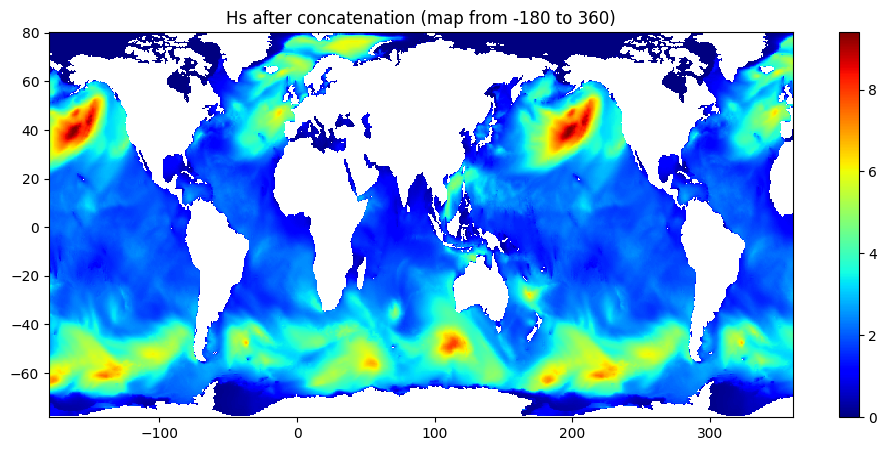

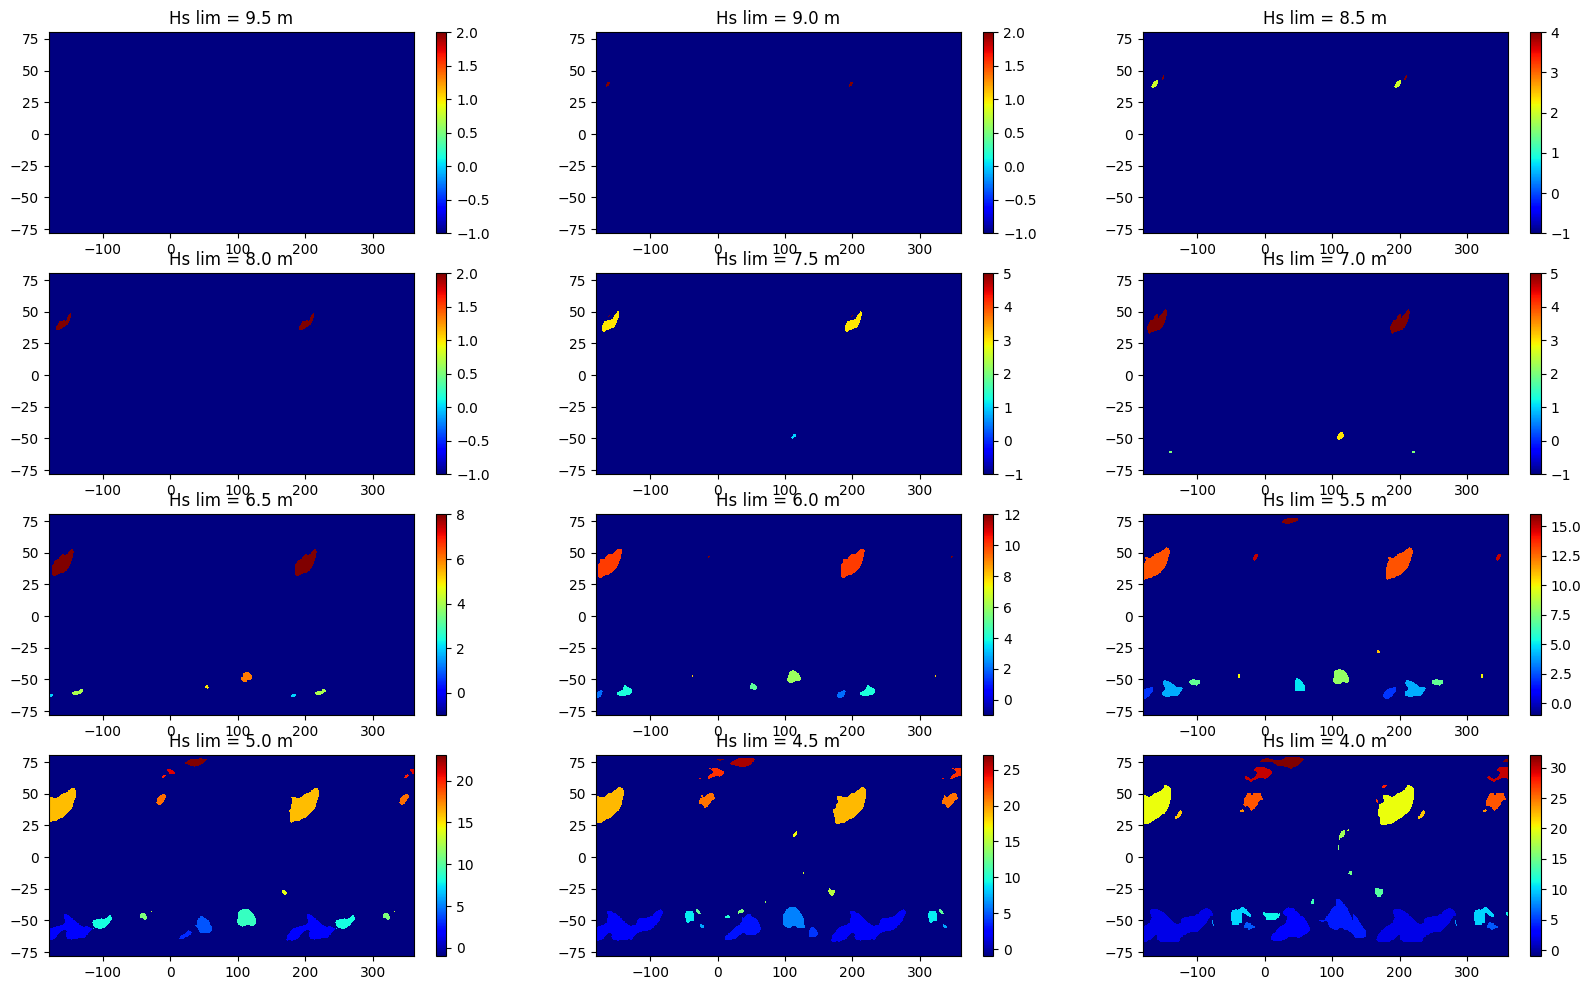

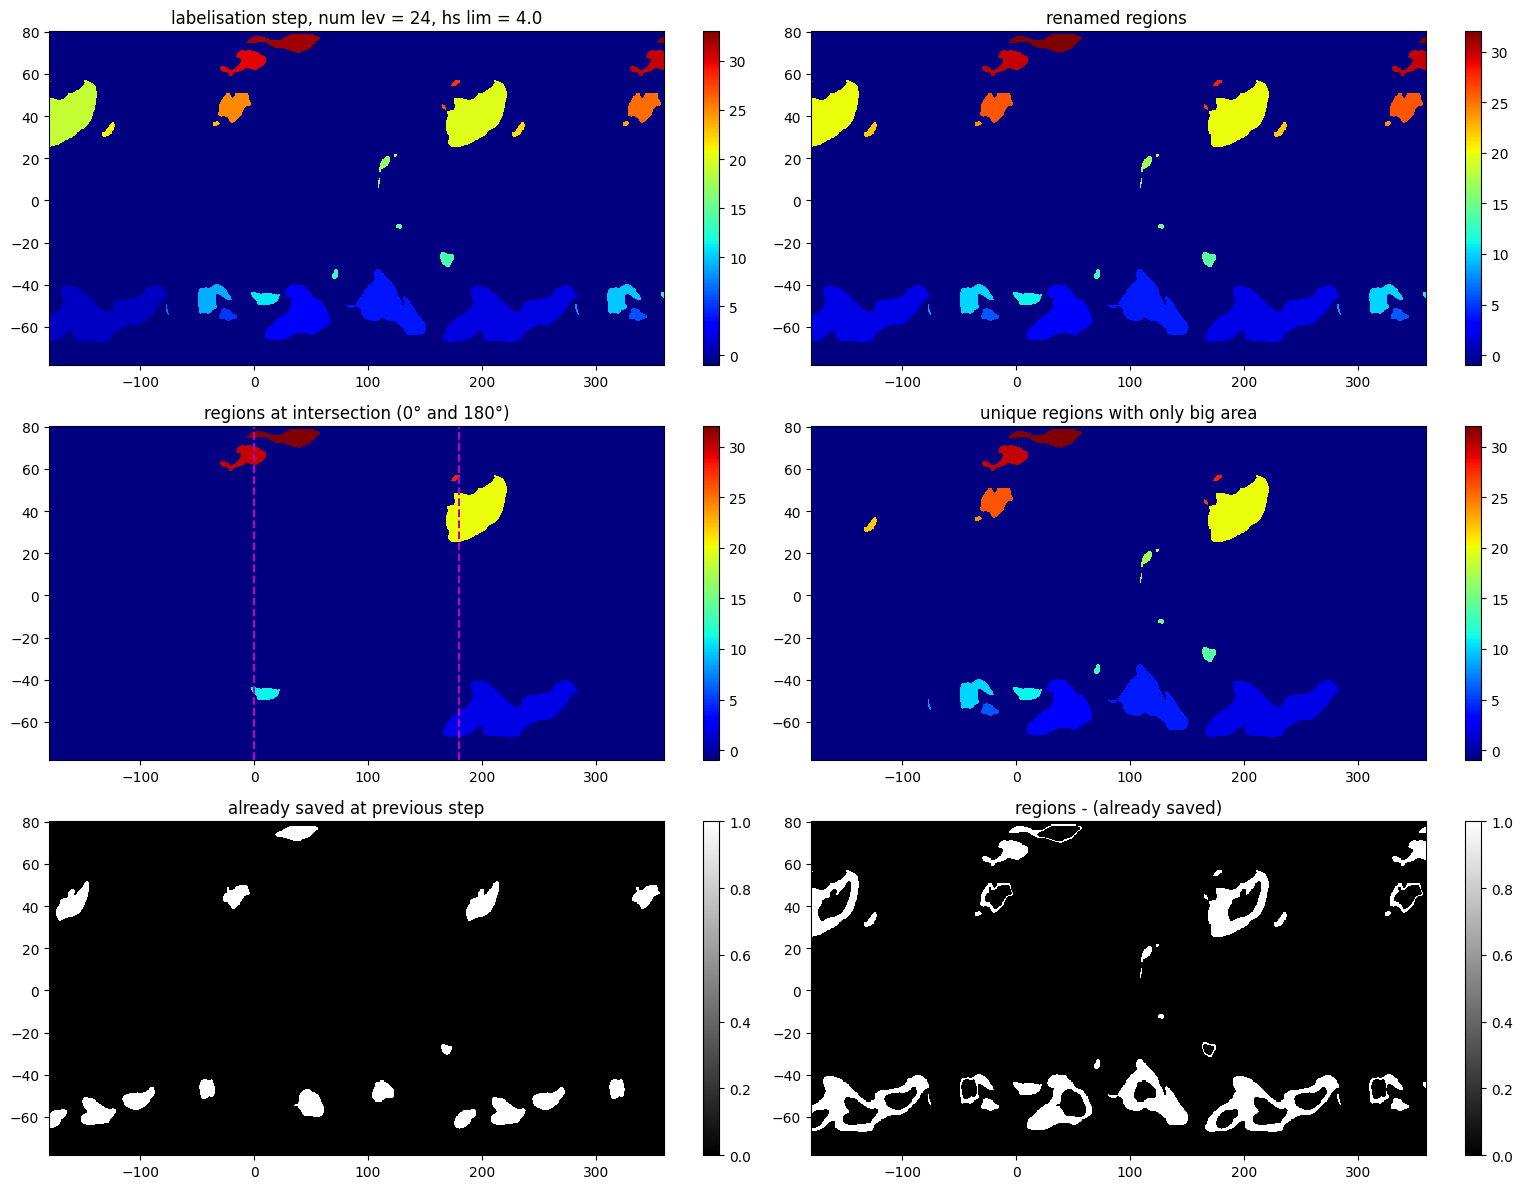

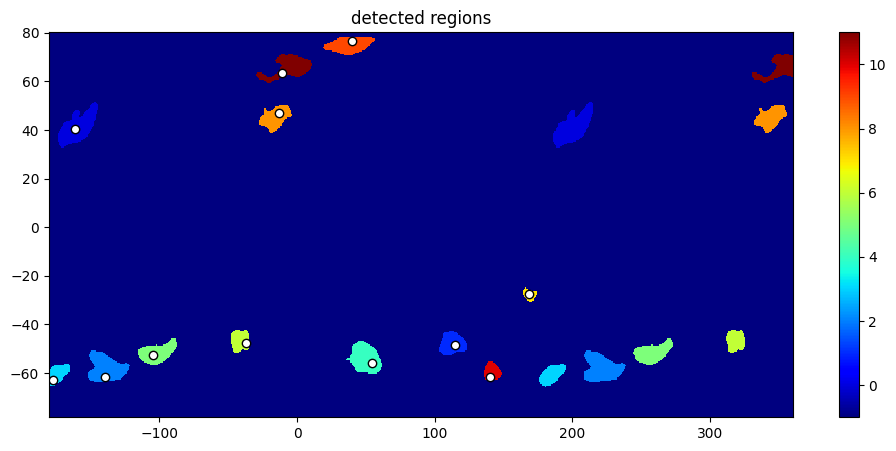

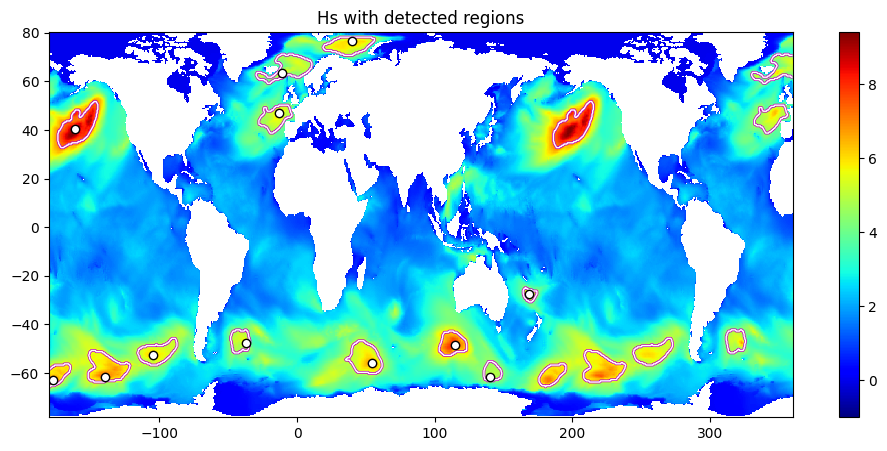

In [27]:
_results, fig_end = get_storm_by_timestep2(ds0, cte.levels, cte.Npix_min, cte.amp_thresh, cte.d_thresh_min, 
                                             cte.d_thresh_max, cte.area_forgotten_ratio, cte.min_area,
                                             plot_output=True,plot_example=True)

### plot_output figures to check algorithm

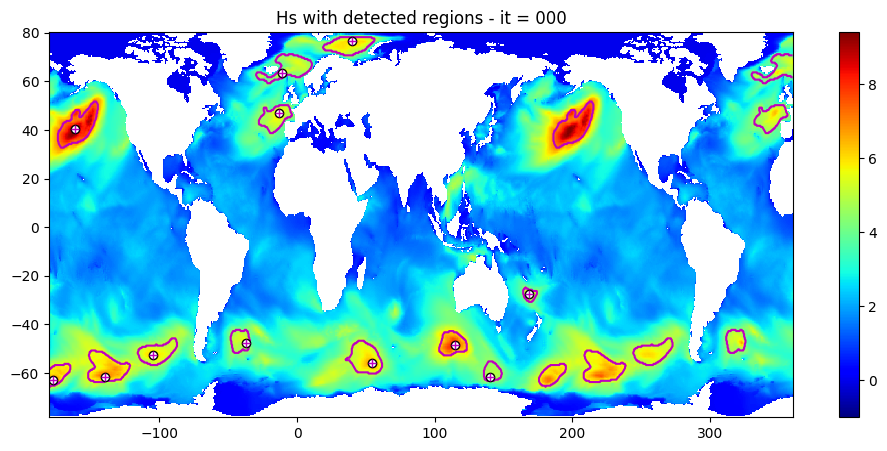

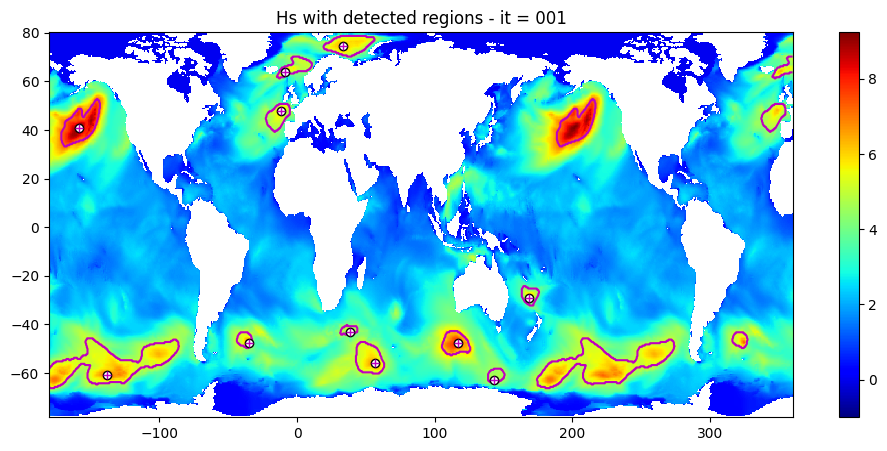

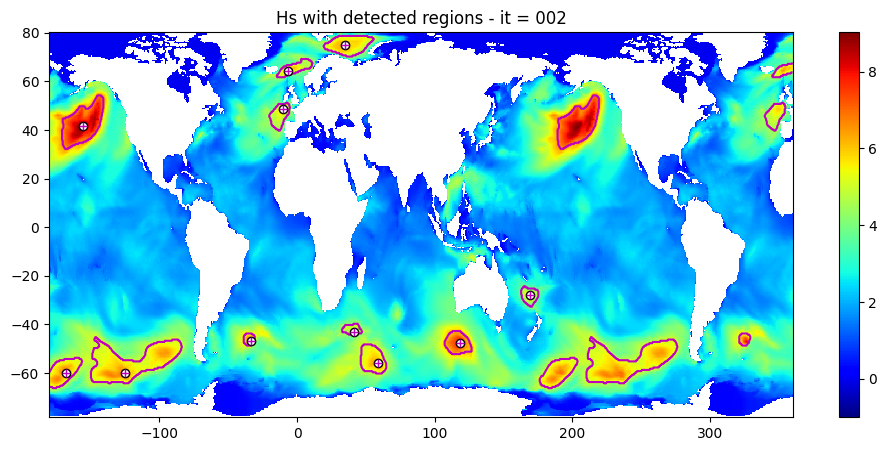

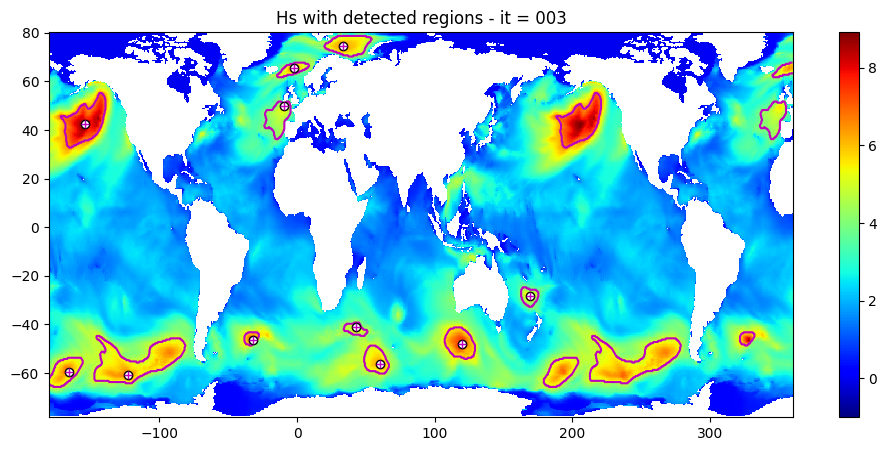

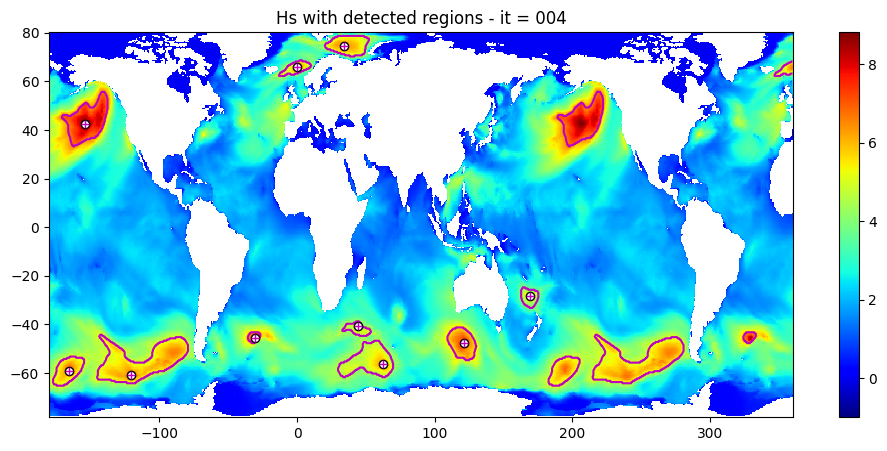

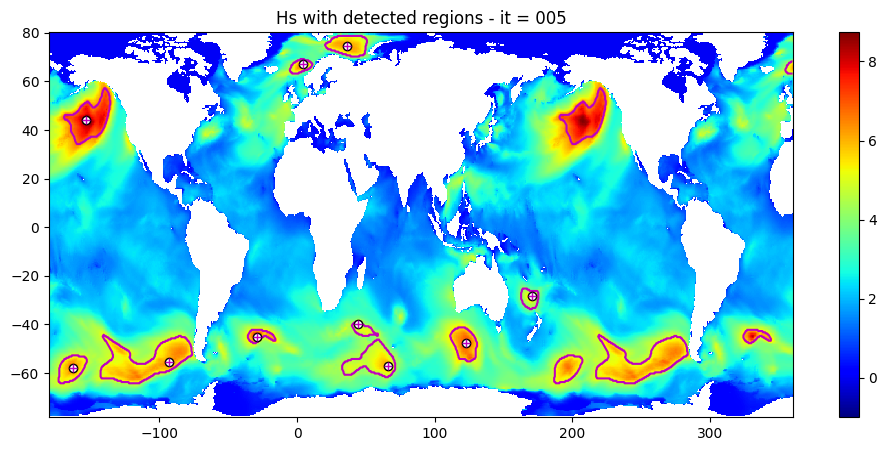

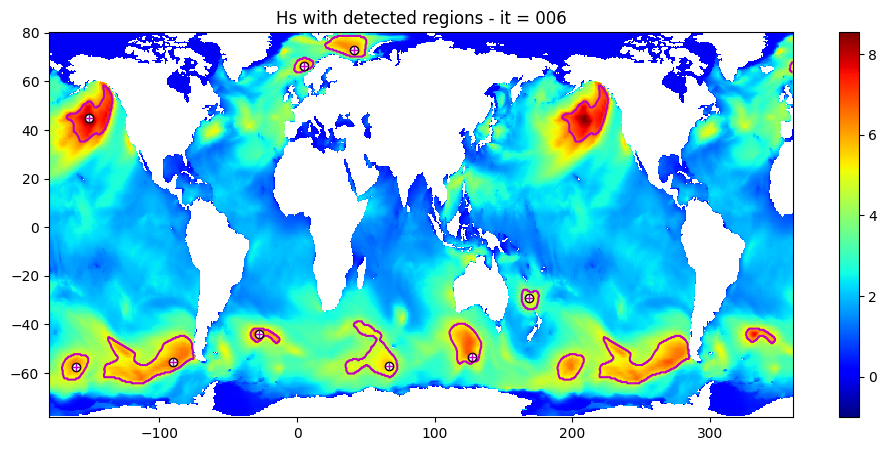

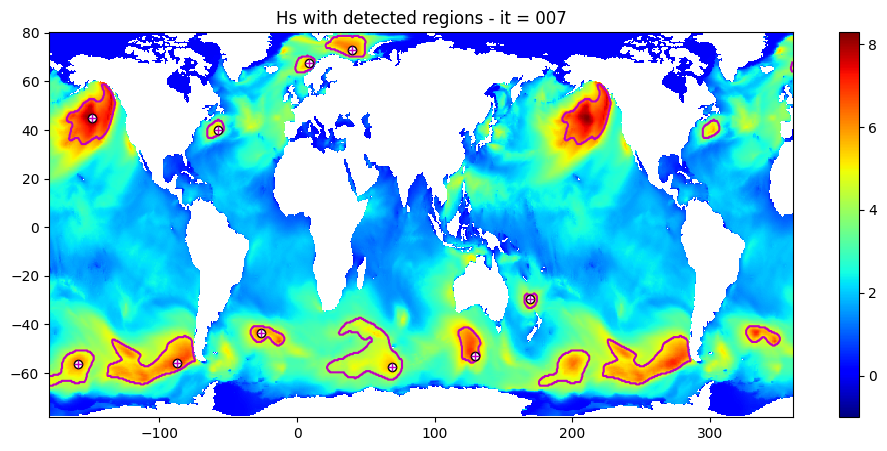

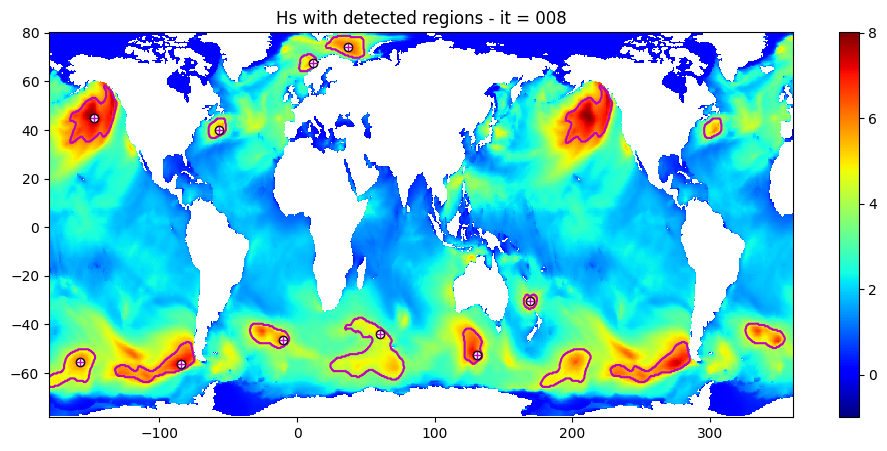

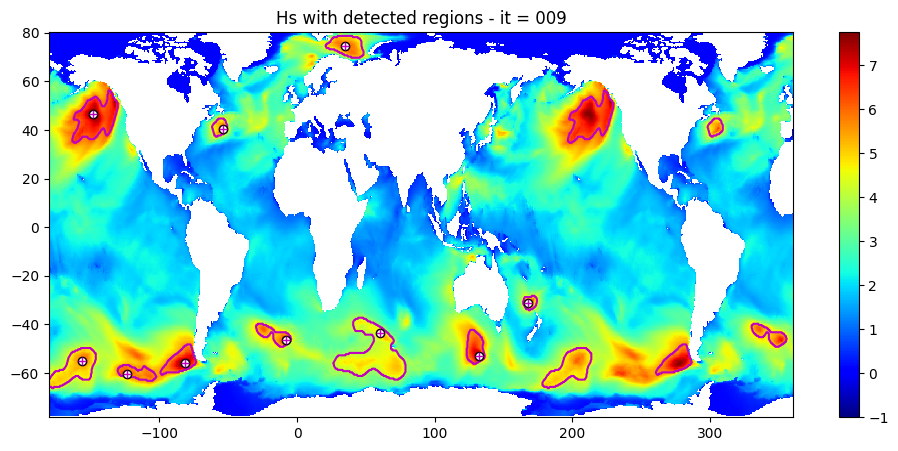

In [8]:
results = []
for it in range(10):
    ds0 = ds.isel(time=it)
    _results, fig_end = get_storm_by_timestep(ds0, cte.levels, cte.Npix_min, cte.amp_thresh, 
                                                 cte.d_thresh_min, cte.d_thresh_max, cte.area_forgotten_ratio, cte.min_area,
                                                 plot_output=True,plot_example=False)	
    results.append(_results)
    plt.figure(fig_end)
    plt.title('Hs with detected regions - it = '+f'{it:03d}')
    # plt.savefig('/home/mdecarlo/Documents/PROJETS/TBH_Tempetes_bdd_historique/Storms_src/output/fig_detect_'+f'{it:03d}'+'.png')
    # plt.close(fig_end)

In [10]:
r_xr = xr.concat(results,dim='x').sortby('time')
r_xr

<xarray.Dataset> Size: 5kB
Dimensions:      (x: 104)
Coordinates:
    time         (x) datetime64[ns] 832B 2023-01-01 ... 2023-01-02T03:00:00
    latitude     (x) float32 416B 40.5 -48.5 -61.5 -63.0 ... 40.5 74.5 -43.5
    longitude    (x) float32 416B -161.5 114.5 -139.5 183.0 ... -54.0 34.5 60.5
    regions      (x) float64 832B 0.0 1.0 2.0 3.0 4.0 ... 5.0 6.0 7.0 8.0 9.0
    storms_by_t  (x) int64 832B 12 12 12 12 12 12 12 12 ... 10 10 10 10 10 10 10
Dimensions without coordinates: x
Data variables:
    lon_max      (x) float64 832B -161.5 114.5 -139.5 -177.0 ... -54.0 34.5 60.5
    lat_max      (x) float32 416B 40.5 -48.5 -61.5 -63.0 ... 40.5 74.5 -43.5
    hs_max       (x) float32 416B 9.398 7.966 7.474 7.172 ... 6.334 5.986 5.506
    areastorm    (x) float32 416B 2.659e+06 1.222e+06 ... 5.711e+05 4.826e+06

In [6]:
r_xr = xr.concat(results,dim='x').sortby('time')
r_xr.to_netcdf(os.path.join(cte.PATH_SAVE_detect,'test_detect.nc'))

In [7]:
for it in range(150):
    ds0 = ds.isel(time=it)
    _results, fig_end = get_storm_by_timestep(ds0, cte.levels, cte.Npix_min, cte.amp_thresh, 
                                                 cte.d_thresh_min, cte.d_thresh_max, cte.area_forgotten_ratio, cte.min_area,
                                                 plot_output=True,plot_example=False)	
    plt.figure(fig_end)
    plt.title('Hs with detected regions - it = '+f'{it:03d}')
    plt.savefig('/home/mdecarlo/Documents/PROJETS/TBH_Tempetes_bdd_historique/Storms_src/output/fig_detect_'+f'{it:03d}'+'.png')
    plt.close(fig_end)

In [7]:
fin = 'test_detect.nc'
fout = 'test_tracking.nc'
disttocoast = xr.open_dataarray(cte.filedist2coast)
import logbook

logbook.StreamHandler(sys.stdout).push_application()
log = logbook.Logger('Python Notebook')


track_for_1_file(fin,fout,cte.PATH_SAVE_detect, cte.PATH_SAVE_tracking, disttocoast,log, threshold_dist=cte.threshold_dist)

[2024-07-19 23:57:34.422769] INFO: Python Notebook: Processing time step 0 over 10
